# Import function of interest

In [16]:
import os
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"
import pandas as pd
import numpy as np
from tqdm import tqdm
import itertools # Pour créer des iterateurs

import matplotlib.pyplot as plt  # Pour l'affichage d'images
from matplotlib import cm # Pour importer de nouvelles cartes de couleur

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier # Pour instancier et entraîner un modèle Random Forest
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn import metrics

from PIL import Image

import tensorflow as tf
#from tensorflow.keras.applications import EfficientNetB1
#from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Conv2D, MaxPooling2D, BatchNormalization, LeakyReLU, Flatten
#from tensorflow.keras.models import Model, Sequential, load_model
#from tensorflow.keras import callbacks

import keras
from keras.applications import ResNet50
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, Conv2D, MaxPooling2D, BatchNormalization, LeakyReLU, Flatten
from keras.models import Model, Sequential, load_model
from keras import callbacks


%matplotlib inline

# Set path(s) :

In [17]:
csv_5fam = "/Users/Adrien/DataScientist/projet_Mushroom/reduced_dataset_5_families.csv"

### Load data:

In [18]:
df = pd.read_csv(csv_5fam)

df.head()

,image_id,image_url,family,filepath,label
0,28,http://mushroomobserver.org/images/320/28,Inocybaceae,/Users/Adrien/DataScientist/projet_Mushroom/im...,0
1,86,http://mushroomobserver.org/images/320/86,Physalacriaceae,/Users/Adrien/DataScientist/projet_Mushroom/im...,3
2,87,http://mushroomobserver.org/images/320/87,Physalacriaceae,/Users/Adrien/DataScientist/projet_Mushroom/im...,3
3,126,http://mushroomobserver.org/images/320/126,Omphalotaceae,/Users/Adrien/DataScientist/projet_Mushroom/im...,1
4,128,http://mushroomobserver.org/images/320/128,Omphalotaceae,/Users/Adrien/DataScientist/projet_Mushroom/im...,1


### Split data :

In [4]:
#X_train_path, X_test_path, y_train, y_test = train_test_split(df['filepath'], df['label'], test_size=0.2, random_state=42)

In [19]:
df2 = df.drop(['image_id', 'image_url'], axis=1)
data_train, data_test = train_test_split(df2, test_size=0.2, random_state=123)
data_train.head()

,family,filepath,label
3946,Fomitopsidaceae,/Users/Adrien/DataScientist/projet_Mushroom/im...,2
12669,Omphalotaceae,/Users/Adrien/DataScientist/projet_Mushroom/im...,1
8382,Omphalotaceae,/Users/Adrien/DataScientist/projet_Mushroom/im...,1
12482,Omphalotaceae,/Users/Adrien/DataScientist/projet_Mushroom/im...,1
4201,Physalacriaceae,/Users/Adrien/DataScientist/projet_Mushroom/im...,3


### Define the ImageDataGenerator

In [20]:
from tensorflow.keras.applications.resnet50 import preprocess_input
#from efficientnet.keras import preprocess_input

train_data_generator = ImageDataGenerator(preprocessing_function=preprocess_input,
                                          rotation_range=5,
                                          width_shift_range = 0.05,
                                          height_shift_range = 0.05,
                                          zoom_range = 1.05,
                                          horizontal_flip = True)

test_data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

## Prepare image

In [22]:
batch_size = 64

data_train["label"] = data_train["label"].astype(str)
data_test["label"] = data_test["label"].astype(str)

train_generator = train_data_generator.flow_from_dataframe(dataframe = data_train, directory="", x_col = "filepath", y_col="label", target_size=(256,256), batch_size=batch_size, class_mode='sparse')
test_generator = test_data_generator.flow_from_dataframe(dataframe = data_test, directory="", x_col = "filepath", y_col="label", target_size=(256,256), batch_size=batch_size, class_mode='sparse')


Found 13709 validated image filenames belonging to 5 classes.
Found 3428 validated image filenames belonging to 5 classes.


/Users/Adrien/opt/anaconda3/envs/transfer_learning_GPU/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/Adrien/opt/anaconda3/envs/transfer_learning_GPU/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


### Load resnet50 pretrained model and freeze layers

In [10]:
resnet50 = ResNet50(include_top=False, input_shape=(256, 256, 3))
for layer in resnet50.layers:
    layer.trainable = False

#resnet50.summary()

INFO:plaidml:Opening device "metal_amd_radeon_pro_5500m.0"
/Users/Adrien/opt/anaconda3/envs/transfer_learning_GPU/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 19s 0us/step


### Define the training model : (sequential)

In [11]:
model_resnet50 = Sequential()
model_resnet50.add(resnet50)
model_resnet50.add(GlobalAveragePooling2D())
model_resnet50.add(Dense(units = 1024, activation = 'relu'))
model_resnet50.add(Dropout(0.3))
model_resnet50.add(Dense(units = 512, activation = 'relu'))
model_resnet50.add(Dropout(0.5))
model_resnet50.add(Dense(units = 5, activation = 'softmax'))

#model_resnet50.summary()

### Compile and train the model

ajout de 2 call backs :
> - Sauvegarder les états intermédiaires.
> - Réduire le learning rate si ça stagne.

In [12]:
model_resnet50.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

history_resnet50 = model_resnet50.fit_generator(generator=train_generator, 
                                epochs = 40,
                                steps_per_epoch = len(data_train)//batch_size,
                                validation_data = test_generator,
                                validation_steps = len(data_test)//batch_size)

Epoch 1/40
214/214 [==============================] - 514s 2s/step - loss: 1.4774 - acc: 0.3680 - val_loss: 1.3189 - val_acc: 0.4626
Epoch 2/40
214/214 [==============================] - 544s 3s/step - loss: 1.3176 - acc: 0.4402 - val_loss: 1.0953 - val_acc: 0.5470
Epoch 3/40
214/214 [==============================] - 569s 3s/step - loss: 1.2772 - acc: 0.4612 - val_loss: 1.2107 - val_acc: 0.5083
Epoch 4/40
214/214 [==============================] - 571s 3s/step - loss: 1.2507 - acc: 0.4752 - val_loss: 1.1130 - val_acc: 0.5458
Epoch 5/40
214/214 [==============================] - 566s 3s/step - loss: 1.2360 - acc: 0.4814 - val_loss: 1.1622 - val_acc: 0.5556
Epoch 6/40
214/214 [==============================] - 682s 3s/step - loss: 1.2209 - acc: 0.4901 - val_loss: 1.0273 - val_acc: 0.6026
Epoch 7/40
214/214 [==============================] - 709s 3s/step - loss: 1.2077 - acc: 0.4925 - val_loss: 1.1338 - val_acc: 0.5565
Epoch 8/40
214/214 [==============================] - 715s 3s/step - 

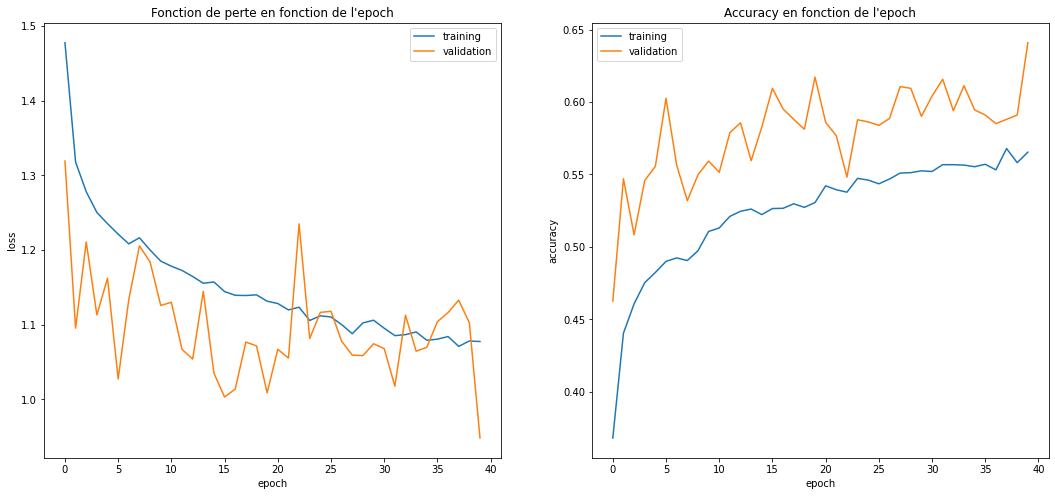

In [13]:
plt.figure(figsize=(18,8))
plt.subplot(121)
plt.plot(range(len(history_resnet50.history['loss'])), history_resnet50.history['loss'], label = "training")
plt.plot(range(len(history_resnet50.history['val_loss'])), history_resnet50.history['val_loss'], label = "validation")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Fonction de perte en fonction de l'epoch")
plt.legend()

plt.subplot(122)
plt.plot(range(len(history_resnet50.history['acc'])), history_resnet50.history['acc'], label = "training")
plt.plot(range(len(history_resnet50.history['val_acc'])), history_resnet50.history['val_acc'], label = "validation")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.title("Accuracy en fonction de l'epoch")
plt.legend();

### Sauvegarder le modèle :

- permet de continuer l'entrainement...
- reloader pour faire des prédictions plus tard...

In [14]:
### Set the path and name you want !
##
#
save_name = "/Users/Adrien/DataScientist/projet_Mushroom/models_GPU_20210620/model_resnet50_GPU_20210617.h5"
#
##
###


model_resnet50.save(save_name)

# New try : loading the model and change the learning rate.

Not that good...

In [23]:
model = load_model('/Users/Adrien/DataScientist/projet_Mushroom/models_GPU_20210620/model_resnet50_GPU_20210617.h5')

In [27]:
optimizer = keras.optimizers.Adam(lr=0.00001)
model.compile(optimizer = optimizer, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
history_resnet50 = model.fit_generator(generator=train_generator, 
                                epochs = 5,
                                steps_per_epoch = len(data_train)//batch_size,
                                validation_data = test_generator,
                                validation_steps = len(data_test)//batch_size)

Epoch 1/5
214/214 [==============================] - 514s 2s/step - loss: 1.0526 - acc: 0.5704 - val_loss: 1.0107 - val_acc: 0.6121
Epoch 2/5
214/214 [==============================] - 566s 3s/step - loss: 1.0433 - acc: 0.5703 - val_loss: 1.0104 - val_acc: 0.6210
Epoch 3/5
214/214 [==============================] - 590s 3s/step - loss: 1.0393 - acc: 0.5766 - val_loss: 1.0650 - val_acc: 0.6011
Epoch 4/5
214/214 [==============================] - 556s 3s/step - loss: 1.0355 - acc: 0.5753 - val_loss: 1.0158 - val_acc: 0.6174
Epoch 5/5
214/214 [==============================] - 507s 2s/step - loss: 1.0386 - acc: 0.5723 - val_loss: 1.0124 - val_acc: 0.6159


In [28]:
### Set the path and name you want !
##
#
save_name = "/Users/Adrien/DataScientist/projet_Mushroom/models_GPU_20210620/model_resnet50_decreased_LR_GPU_20210617.h5"
#
##
###


model.save(save_name)